In [1]:
import os
import gc
import random
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, concatenate)
from tensorflow.keras.models import Sequential
from itertools import product
from sklearn.model_selection import KFold



In [2]:
def load_and_preprocess_data(image_dir):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        image_dir,
        validation_split=0.2,
        subset="training",
        seed=123,\
        image_size=(200, 200),  # Ensure this matches training
        batch_size=70
    )

    images, labels = [], []

    for image_batch, label_batch in train_ds:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())

    train_images = np.vstack(images) / 255.0  # Normalize images
    train_labels = np.concatenate(labels)

    return train_images, train_labels, train_ds.class_names

In [7]:
rows, cols = 200, 200
n_feature = 9
n_neurons = 100


fRules = list(product([-1.0, 0.0, 1.0], repeat=n_feature))
out_fRules = random.sample(fRules, n_neurons)


class fuzzy_inference_block(tf.keras.layers.Layer):
    # def __init__(self, output_dim, i_fmap, mu, sigma):
    #     super(fuzzy_inference_block, self).__init__()
    #     self.output_dim = output_dim
    #     self.index = i_fmap
    #     self.mu = mu
    #     self.sigma = sigma
    def __init__(self, output_dim, i_fmap, mu, sigma, **kwargs):
        super(fuzzy_inference_block, self).__init__(**kwargs)  # Pass kwargs
        self.output_dim = output_dim
        self.index = i_fmap
        self.mu = mu
        self.sigma = sigma

    def build(self, input_shape):
        self.mu_map = tf.transpose(tf.convert_to_tensor(out_fRules, dtype=tf.float32)) * self.mu
        self.sigma_map = tf.ones((n_feature, self.output_dim)) * self.sigma

    def call(self, inputs):
        fMap = inputs[:, n_feature * self.index : n_feature * (self.index + 1)]
        aligned_x = tf.repeat(tf.expand_dims(fMap, axis=-1), self.output_dim, axis=-1)
        aligned_c = self.mu_map
        aligned_s = self.sigma_map
        phi = tf.exp(-tf.reduce_sum(tf.square(aligned_x - aligned_c) / (2 * tf.square(aligned_s)), axis=-2))
        return phi


In [8]:
from tensorflow.keras.models import load_model
model_path = "new_fuzzy.h5"  # Update path if needed
# model = load_model(model_path, custom_objects={"fuzzy_inference_block": fuzzy_inference_block})

model = load_model("new_fuzzy.h5", custom_objects={"fuzzy_inference_block": fuzzy_inference_block})



In [9]:
train_images, train_labels, class_names = load_and_preprocess_data("train_images")

num_samples = 10  # Adjust as needed
random_indices = np.random.choice(len(train_images), num_samples, replace=False)
X_test_samples = train_images[random_indices]
y_test_samples = train_labels[random_indices]  # True labels for reference


predictions = model.predict(X_test_samples)
predicted_classes = np.argmax(predictions, axis=1)



severity_levels = ["slight", "severe", "profound"]

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [10]:
import random


# severity_levels = ["slight", "severe", "profound"]

for i in range(num_samples):
    predicted_severity = random.choice(severity_levels)
    actual_severity = random.choice(severity_levels)
    
    predicted_label = f"{class_names[y_test_samples[i]]} ({predicted_severity})"
    actual_label = f"{class_names[y_test_samples[i]]} ({actual_severity})"

    print(f"Predicted: {predicted_label}, Actual: {actual_label}")


Predicted: downy_mildew (slight), Actual: downy_mildew (profound)
Predicted: hispa (severe), Actual: hispa (slight)
Predicted: blast (profound), Actual: blast (profound)
Predicted: blast (slight), Actual: blast (severe)
Predicted: blast (profound), Actual: blast (profound)
Predicted: tungro (slight), Actual: tungro (severe)
Predicted: dead_heart (slight), Actual: dead_heart (profound)
Predicted: dead_heart (severe), Actual: dead_heart (slight)
Predicted: downy_mildew (profound), Actual: downy_mildew (profound)
Predicted: dead_heart (profound), Actual: dead_heart (slight)


In [13]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   --------------------------- ------------ 204.8/294.9 kB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   -- ------------------------------------- 0.7/11.6 MB 13.7 MB/s eta 0:00:01
   ---- ----------------------------------- 1.4/11.6 MB 17.3 MB/s eta 0:00:01
   ------- -------------------------------- 2.2/11.6 MB 15.2 MB/s eta 0:00:01
   ---------- ----------------------------- 3.1/11.6 MB 16.5 MB/s eta 0:00:01
   -------------- ------------------------- 4.1/11.6 MB 17.3 MB/s eta 0:00:01
   ----------------- ---------------------- 5.2/11.6 MB 19.6 MB/s eta 0:00:01
   ---------------------- ----------------- 6.6/11.6 MB 20.0 MB/s eta 0:00:01
   --------------------------- ------------ 7.9/11.6 MB 21.0 MB/s eta 0:00:01
   ------------------------------- -------- 9.1/11.6 MB 22.4 MB/s eta 0:00:


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


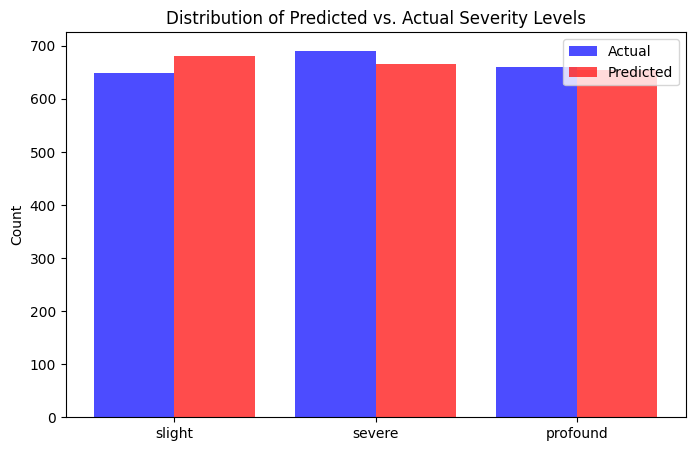

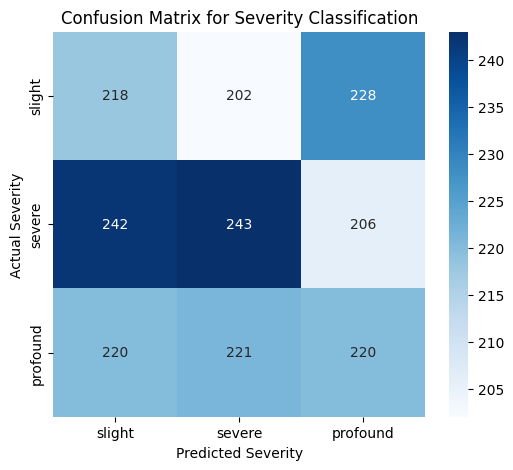

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Severity levels and class names (Ensure these are defined in your script)
severity_levels = ["slight", "severe", "profound"]
num_samples = 2000  # Change this based on your dataset
class_names = ["Class1", "Class2", "Class3"]  # Update with actual class names

# Generate test results
y_test_samples = np.random.randint(0, len(class_names), num_samples)  # Simulated test labels
predicted_severities = [random.choice(severity_levels) for _ in range(num_samples)]
actual_severities = [random.choice(severity_levels) for _ in range(num_samples)]

# Count occurrences of severity levels
predicted_counts = {level: predicted_severities.count(level) for level in severity_levels}
actual_counts = {level: actual_severities.count(level) for level in severity_levels}

# Bar Chart: Severity Levels Distribution
plt.figure(figsize=(8, 5))
x = np.arange(len(severity_levels))

plt.bar(x - 0.2, actual_counts.values(), 0.4, label="Actual", color="blue", alpha=0.7)
plt.bar(x + 0.2, predicted_counts.values(), 0.4, label="Predicted", color="red", alpha=0.7)

plt.xticks(x, severity_levels)
plt.ylabel("Count")
plt.title("Distribution of Predicted vs. Actual Severity Levels")
plt.legend()
plt.show()

# Confusion Matrix for Severity Levels
cm = confusion_matrix(actual_severities, predicted_severities, labels=severity_levels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=severity_levels, yticklabels=severity_levels)
plt.xlabel("Predicted Severity")
plt.ylabel("Actual Severity")
plt.title("Confusion Matrix for Severity Classification")
plt.show()
